# Operational Efficiency Benchmarking for Candy Distribution

## Load Data

In [385]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [386]:
raw_data_path_prefix = 'data/raw/'

tables_dict = {
    'Sales': 'Candy_Sales.csv',
    'Factories': 'Candy_Factories.csv',
    'Products': 'Candy_Products.csv',
    'Targets': 'Candy_Targets.csv',
    'US Zips': 'uszips.csv',
}

df_sales = pd.read_csv(raw_data_path_prefix + tables_dict['Sales'])
df_factories = pd.read_csv(raw_data_path_prefix + tables_dict['Factories'])
df_products = pd.read_csv(raw_data_path_prefix + tables_dict['Products'])
df_targets = pd.read_csv(raw_data_path_prefix + tables_dict['Targets'])
df_zips = pd.read_csv(raw_data_path_prefix + tables_dict['US Zips'])

In [387]:
df_dict = {
    'Sales': df_sales,
    'Factories': df_factories,
    'Products': df_products,
    'Targets': df_targets,
    'US Zips': df_zips
}

In [388]:
for df_name, df in df_dict.items():
    print(f'{df_name}:\n{df.shape}\nContains null values: {df.isnull().sum().any()}\n')

Sales:
(10194, 18)
Contains null values: False

Factories:
(5, 3)
Contains null values: False

Products:
(15, 6)
Contains null values: False

Targets:
(3, 2)
Contains null values: False

US Zips:
(33787, 18)
Contains null values: True



## Clean `df_zips`

In [389]:
df_zips.isnull().sum()

zip                     0
lat                     0
lng                     0
city                    0
state_id                0
state_name              0
zcta                    0
parent_zcta         33787
population             17
density                17
county_fips             0
county_name             0
county_weights          0
county_names_all        0
county_fips_all         0
imprecise               0
military                0
timezone                0
dtype: int64

In [390]:
df_zips['parent_zcta'].unique()

array([nan])

In [391]:
df_zips.drop('parent_zcta', axis=1, inplace=True)

In [392]:
df_zips.isnull().sum()

zip                  0
lat                  0
lng                  0
city                 0
state_id             0
state_name           0
zcta                 0
population          17
density             17
county_fips          0
county_name          0
county_weights       0
county_names_all     0
county_fips_all      0
imprecise            0
military             0
timezone             0
dtype: int64

In [393]:
df_zips[df_zips['population'].isnull()]

,zip,lat,lng,city,state_id,state_name,zcta,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone
91,802,18.34349,-64.92870,St Thomas,VI,Virgin Islands,True,NaN,NaN,78030,St. Thomas,"{""78030"": 100}",St. Thomas,78030,False,False,America/St_Thomas
92,820,17.73880,-64.70695,Christiansted,VI,Virgin Islands,True,NaN,NaN,78010,St. Croix,"{""78010"": 100}",St. Croix,78010,False,False,America/St_Thomas
93,830,18.33857,-64.73802,St John,VI,Virgin Islands,True,NaN,NaN,78020,St. John,"{""78020"": 100}",St. John,78020,False,False,America/St_Thomas
94,840,17.72649,-64.84717,Frederiksted,VI,Virgin Islands,True,NaN,NaN,78010,St. Croix,"{""78010"": 100}",St. Croix,78010,False,False,America/St_Thomas
95,850,17.72763,-64.79122,Kingshill,VI,Virgin Islands,True,NaN,NaN,78010,St. Croix,"{""78010"": 100}",St. Croix,78010,False,False,America/St_Thomas
96,851,17.74757,-64.78737,Kingshill,VI,Virgin Islands,True,NaN,NaN,78010,St. Croix,"{""78010"": 100}",St. Croix,78010,False,False,America/St_Thomas
32479,96799,-14.21984,-170.37005,Pago Pago,AS,American Samoa,True,NaN,NaN,60050,Western,"{""60050"": 36.49, ""60010"": 32.58, ""60020"": 29.1...",Western|Eastern|Manu'a|Swains Island,60050|60010|60020|60040,False,False,Pacific/Pago_Pago
32500,96910,13.45472,144.75128,Hagatna,GU,Guam,True,NaN,NaN,66010,Guam,"{""66010"": 100}",Guam,66010,False,False,Pacific/Guam
32501,96913,13.47825,144.81519,Barrigada,GU,Guam,True,NaN,NaN,66010,Guam,"{""66010"": 100}",Guam,66010,False,False,Pacific/Guam
32502,96915,13.37526,144.70714,Santa Rita,GU,Guam,True,NaN,NaN,66010,Guam,"{""66010"": 100}",Guam,66010,False,False,Pacific/Guam


In [394]:
df_zips.drop_duplicates(inplace=True)

In [395]:
def fill_missing_values_native(df, column, group_column):
    df[column] = df[column].fillna(df.groupby(group_column)[column].transform('mean'))

fill_missing_values_native(df_zips, 'population', 'county_name')
fill_missing_values_native(df_zips, 'population', 'state_name')
fill_missing_values_native(df_zips, 'density', 'county_name')
fill_missing_values_native(df_zips, 'density', 'state_name')

In [396]:
population_dict = {
    'Guam': 154000,
    'Northern Mariana Islands': 48000,
    'American Samoa': 50000
}

density_dict = {
    'Guam': 313,
    'Northern Mariana Islands': 96,
    'American Samoa': 259
}

for state, population in population_dict.items():
    df_zips.loc[(df_zips['population'].isnull()) & (df_zips['state_name'] == state), 'population'] = population
    df_zips.loc[(df_zips['density'].isnull()) & (df_zips['state_name'] == state), 'density'] = density_dict[state]

In [397]:
for df_name, df in df_dict.items():
    print(f'{df_name}:\n{df.shape}\nContains null values: {df.isnull().sum().any()}\n')

Sales:
(10194, 18)
Contains null values: False

Factories:
(5, 3)
Contains null values: False

Products:
(15, 6)
Contains null values: False

Targets:
(3, 2)
Contains null values: False

US Zips:
(33787, 17)
Contains null values: False



In [398]:
# Fix df_zips column naming scheme
name_mapping = {
    'zip': 'Postal Code',
    'lat': 'Latitude',
    'lng': 'Longitude',
    'city': 'City',
    'state_id': 'State ID',
    'state_name': 'State Name',
    'zcta': 'ZCTA',
    'population': 'Population',
    'density': 'Density',
    'county_fips': 'County FIPS',
    'county_name': 'County Name',
    'county_weights': 'County Weights',
    'county_names_all': 'County Names All',
    'county_fips_all': 'County FIPS All',
    'imprecise': 'Imprecise',
    'military': 'Military',
    'timezone': 'Timezone'
}

df_zips.rename(columns=name_mapping, inplace=True)

df_zips['Postal Code'] = df_zips['Postal Code'].astype(object)

## Check Remaining Columns

### Factories Table

In [399]:
df_factories.head()

,Factory,Latitude,Longitude
0,Lot's O' Nuts,32.881893,-111.768036
1,Wicked Choccy's,32.076176,-81.088371
2,Sugar Shack,48.119140,-96.181150
3,Secret Factory,41.446333,-90.565487
4,The Other Factory,35.117500,-89.971107


In [400]:
df_factories.describe(include='all')

,Factory,Latitude,Longitude
count,5,5.000000,5.000000
unique,5,NaN,NaN
top,Lot's O' Nuts,NaN,NaN
freq,1,NaN,NaN
mean,NaN,37.928208,-93.914830
std,NaN,6.779453,11.348593
min,NaN,32.076176,-111.768036
25%,NaN,32.881893,-96.181150
50%,NaN,35.117500,-90.565487
75%,NaN,41.446333,-89.971107


In [401]:
df_factories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Factory    5 non-null      object 
 1   Latitude   5 non-null      float64
 2   Longitude  5 non-null      float64
dtypes: float64(2), object(1)
memory usage: 252.0+ bytes


In [402]:
df_factories['Factory'].unique()

array(["Lot's O' Nuts", "Wicked Choccy's", 'Sugar Shack',
       'Secret Factory', 'The Other Factory'], dtype=object)

### Sales Table

In [403]:
df_sales.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Country/Region,City,State/Province,Postal Code,Division,Region,Product ID,Product Name,Sales,Units,Gross Profit,Cost
0,282,US-2021-128055-CHO-TRI-54000,2021-03-31,2026-09-26,Standard Class,128055,United States,San Francisco,California,94122,Chocolate,Pacific,CHO-TRI-54000,Wonka Bar - Triple Dazzle Caramel,7.50,2,4.90,2.60
1,288,US-2021-128055-CHO-SCR-58000,2021-03-31,2026-09-26,Standard Class,128055,United States,San Francisco,California,94122,Chocolate,Pacific,CHO-SCR-58000,Wonka Bar -Scrumdiddlyumptious,7.20,2,5.00,2.20
2,1132,US-2021-138100-CHO-FUD-51000,2021-09-15,2027-03-13,Standard Class,138100,United States,New York City,New York,10011,Chocolate,Atlantic,CHO-FUD-51000,Wonka Bar - Fudge Mallows,7.20,2,4.80,2.40
3,1133,US-2021-138100-CHO-MIL-31000,2021-09-15,2027-03-13,Standard Class,138100,United States,New York City,New York,10011,Chocolate,Atlantic,CHO-MIL-31000,Wonka Bar - Milk Chocolate,9.75,3,6.33,3.42
4,3396,US-2022-121391-CHO-MIL-31000,2022-10-04,2028-03-29,First Class,121391,United States,San Francisco,California,94109,Chocolate,Pacific,CHO-MIL-31000,Wonka Bar - Milk Chocolate,6.50,2,4.22,2.28


In [404]:
df_sales.describe(include='all')

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Country/Region,City,State/Province,Postal Code,Division,Region,Product ID,Product Name,Sales,Units,Gross Profit,Cost
count,10194.000000,10194,10194,10194,10194,10194.000000,10194,10194,10194,10194,10194,10194,10194,10194,10194.000000,10194.000000,10194.000000,10194.000000
unique,NaN,8549,1242,1338,4,NaN,2,542,59,654,3,4,15,15,NaN,NaN,NaN,NaN
top,NaN,US-2024-113278-CHO-MIL-31000,2023-09-05,2028-06-07,Standard Class,NaN,United States,New York City,California,10035,Chocolate,Pacific,CHO-MIL-31000,Wonka Bar - Milk Chocolate,NaN,NaN,NaN,NaN
freq,NaN,5,38,38,6120,NaN,9994,915,2001,263,9844,3253,2137,2137,NaN,NaN,NaN,NaN
mean,5097.500000,NaN,NaN,NaN,NaN,134468.961154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.908537,3.791838,9.166451,4.742087
std,2942.898656,NaN,NaN,NaN,NaN,20231.483007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.341020,2.228317,6.643740,5.061647
min,1.000000,NaN,NaN,NaN,NaN,100006.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.250000,1.000000,0.250000,0.600000
25%,2549.250000,NaN,NaN,NaN,NaN,117212.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.200000,2.000000,4.900000,2.400000
50%,5097.500000,NaN,NaN,NaN,NaN,133550.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.800000,3.000000,7.470000,3.600000
75%,7645.750000,NaN,NaN,NaN,NaN,152051.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.000000,5.000000,12.250000,5.700000


In [405]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10194 entries, 0 to 10193
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Row ID          10194 non-null  int64  
 1   Order ID        10194 non-null  object 
 2   Order Date      10194 non-null  object 
 3   Ship Date       10194 non-null  object 
 4   Ship Mode       10194 non-null  object 
 5   Customer ID     10194 non-null  int64  
 6   Country/Region  10194 non-null  object 
 7   City            10194 non-null  object 
 8   State/Province  10194 non-null  object 
 9   Postal Code     10194 non-null  object 
 10  Division        10194 non-null  object 
 11  Region          10194 non-null  object 
 12  Product ID      10194 non-null  object 
 13  Product Name    10194 non-null  object 
 14  Sales           10194 non-null  float64
 15  Units           10194 non-null  int64  
 16  Gross Profit    10194 non-null  float64
 17  Cost            10194 non-null 

In [406]:
# Convert Date Columns
df_sales['Order Date'] = pd.to_datetime(df_sales['Order Date'])
df_sales['Ship Date'] = pd.to_datetime(df_sales['Ship Date'])

In [407]:
df_sales['Order ID'].value_counts()

Order ID
US-2024-113278-CHO-MIL-31000    5
US-2024-100111-CHO-NUT-13000    5
US-2022-130974-CHO-SCR-58000    5
US-2022-112130-CHO-FUD-51000    5
US-2024-157987-CHO-NUT-13000    5
                               ..
US-2021-126802-CHO-SCR-58000    1
US-2022-133452-CHO-TRI-54000    1
US-2022-133452-CHO-SCR-58000    1
US-2022-115567-CHO-NUT-13000    1
US-2022-115567-CHO-TRI-54000    1
Name: count, Length: 8549, dtype: int64

In [408]:
df_sales['Product ID'].value_counts()

Product ID
CHO-MIL-31000    2137
CHO-SCR-58000    2064
CHO-TRI-54000    2015
CHO-FUD-51000    1818
CHO-NUT-13000    1810
OTH-GUM-21000     120
OTH-KAZ-38000      96
OTH-LIC-15000      94
SUG-SWE-91000      10
SUG-LAF-25000      10
OTH-FIZ-56000       6
SUG-HAI-55000       4
SUG-NER-92000       4
SUG-EVE-47000       3
SUG-FUN-75000       3
Name: count, dtype: int64

### Products Table

In [409]:
df_products.head()

,Division,Product Name,Factory,Product ID,Unit Price,Unit Cost
0,Chocolate,Wonka Bar - Nutty Crunch Surprise,Lot's O' Nuts,CHO-NUT-13000,3.49,1.00
1,Chocolate,Wonka Bar - Fudge Mallows,Lot's O' Nuts,CHO-FUD-51000,3.60,1.20
2,Chocolate,Wonka Bar -Scrumdiddlyumptious,Lot's O' Nuts,CHO-SCR-58000,3.60,1.10
3,Chocolate,Wonka Bar - Milk Chocolate,Wicked Choccy's,CHO-MIL-31000,3.25,1.14
4,Chocolate,Wonka Bar - Triple Dazzle Caramel,Wicked Choccy's,CHO-TRI-54000,3.75,1.30


In [410]:
df_products['Division'].unique()

array(['Chocolate', 'Sugar', 'Other'], dtype=object)

In [411]:
df_products.describe(include='all')

,Division,Product Name,Factory,Product ID,Unit Price,Unit Cost
count,15,15,15,15,15.000000,15.000000
unique,3,15,5,15,NaN,NaN
top,Sugar,Wonka Bar - Nutty Crunch Surprise,Sugar Shack,CHO-NUT-13000,NaN,NaN
freq,6,1,5,1,NaN,NaN
mean,NaN,NaN,NaN,NaN,4.462000,1.806000
std,NaN,NaN,NaN,NaN,4.790102,2.344866
min,NaN,NaN,NaN,NaN,1.250000,0.600000
25%,NaN,NaN,NaN,NaN,1.745000,0.850000
50%,NaN,NaN,NaN,NaN,3.490000,1.100000
75%,NaN,NaN,NaN,NaN,3.750000,1.400000


In [412]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Division      15 non-null     object 
 1   Product Name  15 non-null     object 
 2   Factory       15 non-null     object 
 3   Product ID    15 non-null     object 
 4   Unit Price    15 non-null     float64
 5   Unit Cost     15 non-null     float64
dtypes: float64(2), object(4)
memory usage: 852.0+ bytes


### Targets Table

In [413]:
df_targets.head()

,Division,Target
0,Chocolate,27000
1,Sugar,15000
2,Other,3000


In [414]:
df_targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Division  3 non-null      object
 1   Target    3 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 180.0+ bytes


## Remove Duplicates

In [415]:
df_sales.drop_duplicates(inplace=True)
df_products.drop_duplicates(inplace=True)
df_targets.drop_duplicates(inplace=True)
df_zips.drop_duplicates(inplace=True)
df_factories.drop_duplicates(inplace=True)

## SQLite Database

In [416]:
%load_ext sql
%sql sqlite:///sales_data.db
%config SqlMagic.style = '_DEPRECATED_DEFAULT'

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [417]:
import sqlite3

conn = sqlite3.connect('sales_data.db')
df_sales.to_sql('Sales', conn, if_exists='replace', index=False)
df_products.to_sql('Products', conn, if_exists='replace', index=False)
df_targets.to_sql('Targets', conn, if_exists='replace', index=False)
df_zips.to_sql('US Zips', conn, if_exists='replace', index=False)
df_factories.to_sql('Factories', conn, if_exists='replace', index=False)

5

## MySQL Database

In [418]:
import mysql.connector
from dotenv import load_dotenv
import os
import pandas as pd

load_dotenv()
mysql_host = os.getenv('MYSQL_HOST')
mysql_user = os.getenv('MYSQL_USER')
mysql_password = os.getenv('MYSQL_PASSWORD')
mysql_name = os.getenv('MYSQL_NAME')

mydb = mysql.connector.connect(host=mysql_host, user=mysql_user, password=mysql_password, database=mysql_name)


cursor = mydb.cursor()

# Insert data from pandas DataFrames into MySQL tables
for table_name, df in [
    ('sales_t', df_sales),
    ('products_t', df_products),
    ('targets_t', df_targets),
    ('us_zips_t', df_zips),
    ('factories_t', df_factories),
]:
    # Check if the table exists
    cursor.execute(f"SHOW TABLES LIKE '{table_name}'")
    table_exists = cursor.fetchone()

    if not table_exists:
        # Prepare the CREATE TABLE query based on the DataFrame schema
        column_definitions = []
        for column, dtype in df.dtypes.items():
            if dtype == 'int64':
                column_definitions.append(f'`{column}` INT')
            elif dtype == 'float64':
                column_definitions.append(f'`{column}` FLOAT')
            elif dtype == 'datetime64[ns]':
                column_definitions.append(f'`{column}` DATETIME')
            else:
                column_definitions.append(f'`{column}` VARCHAR(255)')

        create_table_query = f'CREATE TABLE `{table_name}` ({", ".join(column_definitions)})'
        try:
            cursor.execute(create_table_query)
            print(f'Table {table_name} created successfully.')
        except mysql.connector.Error as err:
            print(f'Error creating table {table_name}: {err}')
            continue  # Skip to the next table if creation fails

    # Check if the table has data
    cursor.execute(f'SELECT COUNT(*) FROM `{table_name}`')
    count = cursor.fetchone()[0]

    if count == 0:
        # Prepare the insert query
        columns = ', '.join(f'`{col}`' for col in df.columns)
        placeholders = ', '.join(['%s'] * len(df.columns))
        insert_query = f'INSERT INTO `{table_name}` ({columns}) VALUES ({placeholders})'

        # Iterate over DataFrame rows and insert into MySQL
        for _, row in df.iterrows():
            try:
                cursor.execute(insert_query, tuple(row))
            except mysql.connector.Error as err:
                print(f'Error inserting into {table_name}: {err}')
                print(f'Problematic row: {row.to_dict()}')
        print(f'Data inserted into {table_name}')
    else:
        print(f'Table {table_name} already has data, skipping insertion')


# Commit the changes and close the connection
mydb.commit()
cursor.close()
mydb.close()

Table sales_t already has data, skipping insertion
Table products_t already has data, skipping insertion
Table targets_t already has data, skipping insertion
Table us_zips_t already has data, skipping insertion
Table factories_t already has data, skipping insertion


### Test Query: Compare Gross Profit vs Target per Division

In [419]:
%%sql
SELECT *
FROM Sales
ORDER BY "Gross Profit" DESC
LIMIT 5

 * sqlite:///sales_data.db
Done.


Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Country/Region,City,State/Province,Postal Code,Division,Region,Product ID,Product Name,Sales,Units,Gross Profit,Cost
366,US-2021-122336-OTH-LIC-15000,2021-04-13 00:00:00,2026-10-08 00:00:00,Second Class,122336,United States,Philadelphia,Pennsylvania,19140,Other,Atlantic,OTH-LIC-15000,Lickable Wallpaper,260.0,13,130.0,130.0
5828,US-2023-124163-OTH-LIC-15000,2023-09-25 00:00:00,2029-03-22 00:00:00,Standard Class,124163,United States,La Crosse,Wisconsin,54601,Other,Interior,OTH-LIC-15000,Lickable Wallpaper,220.0,11,110.0,110.0
4832,US-2023-107202-OTH-LIC-15000,2023-05-21 00:00:00,2028-11-17 00:00:00,Standard Class,107202,United States,Sparks,Nevada,89431,Other,Pacific,OTH-LIC-15000,Lickable Wallpaper,200.0,10,100.0,100.0
6473,US-2023-164770-OTH-LIC-15000,2023-12-02 00:00:00,2029-05-26 00:00:00,Second Class,164770,United States,Houston,Texas,77036,Other,Interior,OTH-LIC-15000,Lickable Wallpaper,200.0,10,100.0,100.0
6981,US-2024-164147-OTH-LIC-15000,2024-02-02 00:00:00,2029-07-28 00:00:00,First Class,164147,United States,Columbus,Ohio,43229,Other,Atlantic,OTH-LIC-15000,Lickable Wallpaper,180.0,9,90.0,90.0


In [420]:
%%sql
WITH
    DivisionTargets AS (
        SELECT
            Division,
            Target AS TargetGrossProfit
        FROM Targets
    )
SELECT
    s.Division,
    SUM(s."Gross Profit") AS TotalGrossProfit,
    dt.TargetGrossProfit,
    CASE
        WHEN SUM(s."Gross Profit") > dt.TargetGrossProfit THEN 'Exceeds Target'
        ELSE 'Falls Below Target'
    END AS Status,
    ROUND(
        SUM(s."Gross Profit") - dt.TargetGrossProfit,
        2
    ) AS Difference,
    ROUND(
        (
            SUM(s."Gross Profit") - dt.TargetGrossProfit
        ) / dt.TargetGrossProfit * 100,
        2
    ) AS PercentChange
FROM
    Sales s
    LEFT JOIN Products p ON s."Product ID" = p."Product ID"
    JOIN DivisionTargets dt ON s.Division = dt.Division
GROUP BY
    s.Division,
    dt.TargetGrossProfit
LIMIT 5;

 * sqlite:///sales_data.db
Done.


Division,TotalGrossProfit,TargetGrossProfit,Status,Difference,PercentChange
Chocolate,88824.62,27000,Exceeds Target,61824.62,228.98
Other,4333.45,3000,Exceeds Target,1333.45,44.45
Sugar,284.73,15000,Falls Below Target,-14715.27,-98.1


### Testing within Python

In [421]:
sql_query = """
WITH
    DivisionTargets AS (
        SELECT
            Division,
            Target AS TargetGrossProfit
        FROM Targets
    )
SELECT
    s.Division,
    SUM(s."Gross Profit") AS TotalGrossProfit,
    dt.TargetGrossProfit,
    CASE
        WHEN SUM(s."Gross Profit") > dt.TargetGrossProfit THEN 'Exceeds Target'
        ELSE 'Falls Below Target'
    END AS Status,
    ROUND(
        SUM(s."Gross Profit") - dt.TargetGrossProfit,
        2
    ) AS Difference,
    ROUND(
        (
            SUM(s."Gross Profit") - dt.TargetGrossProfit
        ) / dt.TargetGrossProfit * 100,
        2
    ) AS PercentChange
FROM
    Sales s
    LEFT JOIN Products p ON s."Product ID" = p."Product ID"
    JOIN DivisionTargets dt ON s.Division = dt.Division
GROUP BY
    s.Division,
    dt.TargetGrossProfit
LIMIT 5;
"""

cursor = conn.cursor()
cursor.execute(sql_query)
results = cursor.fetchall()
column_names = [description[0] for description in cursor.description]
results_df = pd.DataFrame(results, columns=column_names)

results_df

,Division,TotalGrossProfit,TargetGrossProfit,Status,Difference,PercentChange
0,Chocolate,88824.62,27000,Exceeds Target,61824.62,228.98
1,Other,4333.45,3000,Exceeds Target,1333.45,44.45
2,Sugar,284.73,15000,Falls Below Target,-14715.27,-98.10


### Combine Into Single DataFrame (For EDA)

In [422]:
# Print column names as reference
for df_name, df in df_dict.items():
    print(f'{df_name}\n\n{df.columns}\n————————————————————————————————————')

Sales

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Country/Region', 'City', 'State/Province',
       'Postal Code', 'Division', 'Region', 'Product ID', 'Product Name',
       'Sales', 'Units', 'Gross Profit', 'Cost'],
      dtype='object')
————————————————————————————————————
Factories

Index(['Factory', 'Latitude', 'Longitude'], dtype='object')
————————————————————————————————————
Products

Index(['Division', 'Product Name', 'Factory', 'Product ID', 'Unit Price',
       'Unit Cost'],
      dtype='object')
————————————————————————————————————
Targets

Index(['Division', 'Target'], dtype='object')
————————————————————————————————————
US Zips

Index(['Postal Code', 'Latitude', 'Longitude', 'City', 'State ID',
       'State Name', 'ZCTA', 'Population', 'Density', 'County FIPS',
       'County Name', 'County Weights', 'County Names All', 'County FIPS All',
       'Imprecise', 'Military', 'Timezone'],
      dtype='object')
————————————————————

In [423]:
# Remove duplicated redundant columns

df_sales.drop(columns=['Row ID'], inplace=True)
df_zips.drop(columns=['City', 'Latitude', 'Longitude'], inplace=True)
df_products.drop(columns=['Division', 'Product Name'], inplace=True)

In [424]:
# Merge with left joins
df_combined = pd.merge(df_sales, df_products, how='left', on='Product ID')
df_combined = pd.merge(df_combined, df_factories, how='left', on='Factory')
df_combined = pd.merge(df_combined, df_zips, how='left', on='Postal Code')
df_combined = pd.merge(df_combined, df_targets, how='left', on='Division')

In [425]:
# Remove unnecessary columns
df_combined_modif = df_combined.drop(
    columns=[
        'Order ID',
        'Customer ID',
        'State ID',
        'Product ID',
        'County FIPS',
        'County Name',
        'County Weights',
        'County Names All',
        'County FIPS All',
        'Imprecise',
        'Military',
        'Timezone',
        'Population',
        'Density',
        'ZCTA',
    ]
)

In [426]:
df_combined_modif.head()

,Order Date,Ship Date,Ship Mode,Country/Region,City,State/Province,Postal Code,Division,Region,Product Name,...,Units,Gross Profit,Cost,Factory,Unit Price,Unit Cost,Latitude,Longitude,State Name,Target
0,2021-03-31,2026-09-26,Standard Class,United States,San Francisco,California,94122,Chocolate,Pacific,Wonka Bar - Triple Dazzle Caramel,...,2,4.90,2.60,Wicked Choccy's,3.75,1.30,32.076176,-81.088371,NaN,27000
1,2021-03-31,2026-09-26,Standard Class,United States,San Francisco,California,94122,Chocolate,Pacific,Wonka Bar -Scrumdiddlyumptious,...,2,5.00,2.20,Lot's O' Nuts,3.60,1.10,32.881893,-111.768036,NaN,27000
2,2021-09-15,2027-03-13,Standard Class,United States,New York City,New York,10011,Chocolate,Atlantic,Wonka Bar - Fudge Mallows,...,2,4.80,2.40,Lot's O' Nuts,3.60,1.20,32.881893,-111.768036,NaN,27000
3,2021-09-15,2027-03-13,Standard Class,United States,New York City,New York,10011,Chocolate,Atlantic,Wonka Bar - Milk Chocolate,...,3,6.33,3.42,Wicked Choccy's,3.25,1.14,32.076176,-81.088371,NaN,27000
4,2022-10-04,2028-03-29,First Class,United States,San Francisco,California,94109,Chocolate,Pacific,Wonka Bar - Milk Chocolate,...,2,4.22,2.28,Wicked Choccy's,3.25,1.14,32.076176,-81.088371,NaN,27000


### EDA

In [427]:
sns.set_style('whitegrid')

In [428]:
df = df_combined_modif.copy()

In [429]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10194 entries, 0 to 10193
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Order Date      10194 non-null  datetime64[ns]
 1   Ship Date       10194 non-null  datetime64[ns]
 2   Ship Mode       10194 non-null  object        
 3   Country/Region  10194 non-null  object        
 4   City            10194 non-null  object        
 5   State/Province  10194 non-null  object        
 6   Postal Code     10194 non-null  object        
 7   Division        10194 non-null  object        
 8   Region          10194 non-null  object        
 9   Product Name    10194 non-null  object        
 10  Sales           10194 non-null  float64       
 11  Units           10194 non-null  int64         
 12  Gross Profit    10194 non-null  float64       
 13  Cost            10194 non-null  float64       
 14  Factory         10194 non-null  object        
 15  Un

In [430]:
df.isnull().sum()

Order Date            0
Ship Date             0
Ship Mode             0
Country/Region        0
City                  0
State/Province        0
Postal Code           0
Division              0
Region                0
Product Name          0
Sales                 0
Units                 0
Gross Profit          0
Cost                  0
Factory               0
Unit Price            0
Unit Cost             0
Latitude              0
Longitude             0
State Name        10194
Target                0
dtype: int64

In [431]:
# Drop `State Name` (contains all nulls)
df.drop(columns=['State Name'], inplace=True)

In [432]:
# Export for ease of access
df.to_csv('data/processed/Candy_Distributor_Data_Preprocessed_Merged.csv', index=False)

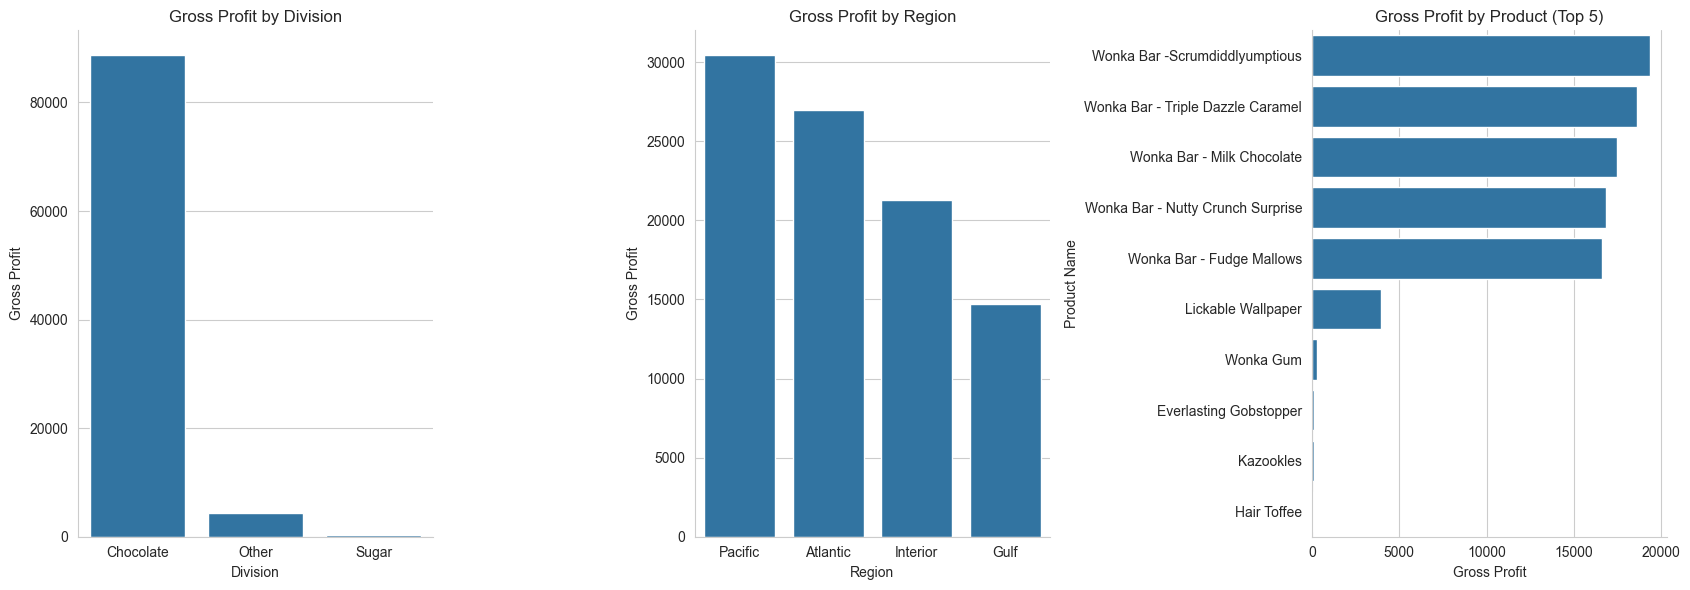

In [444]:
top_10_products_by_profit = df.groupby('Product Name')['Gross Profit'].sum().sort_values(ascending=False).head(10)
df_profit_by_division = df.groupby('Division')['Gross Profit'].sum().sort_values(ascending=False)
df_profit_by_region = df.groupby('Region')['Gross Profit'].sum().sort_values(ascending=False)

fig, axes = plt.subplots(1, 3, figsize=(17, 6))

sns.barplot(data=pd.DataFrame(df_profit_by_division), x='Division', y='Gross Profit', ax=axes[0])
axes[0].set_title(f'Gross Profit by Division')
sns.barplot(data=pd.DataFrame(df_profit_by_region), x='Region', y='Gross Profit', ax=axes[1])
axes[1].set_title(f'Gross Profit by Region')
sns.barplot(data=pd.DataFrame(top_10_products_by_profit), y='Product Name', x='Gross Profit', ax=axes[2])
axes[2].set_title(f'Gross Profit by Product (Top 5)')

plt.tight_layout()
sns.despine()
plt.show()

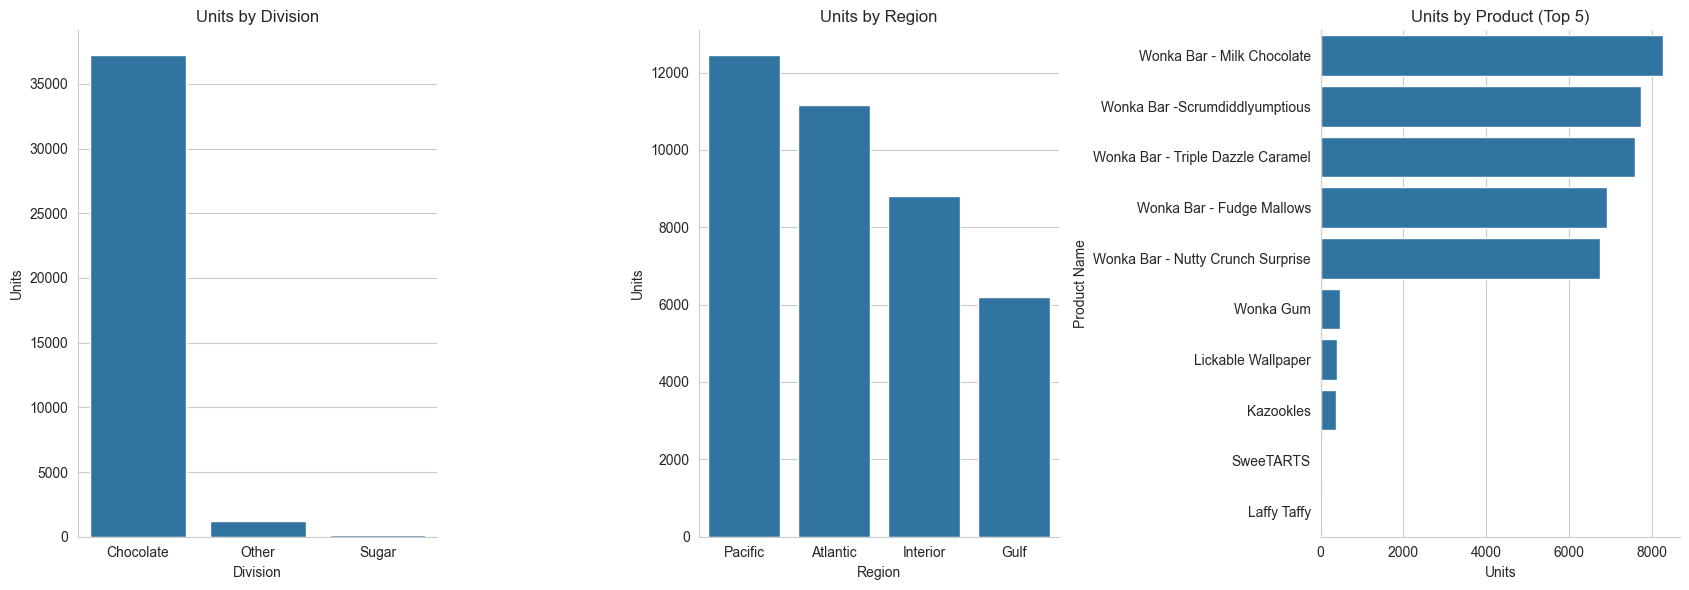

In [443]:
df_units_by_division = df.groupby('Division')['Units'].sum().sort_values(ascending=False)
df_units_by_region = df.groupby('Region')['Units'].sum().sort_values(ascending=False)
top_10_unit_count = df.groupby('Product Name')['Units'].sum().sort_values(ascending=False).head(10)


fig, axes = plt.subplots(1, 3, figsize=(17, 6))

sns.barplot(data=pd.DataFrame(df_units_by_division), x='Division', y='Units', ax=axes[0])
axes[0].set_title(f'Units by Division')
sns.barplot(data=pd.DataFrame(df_units_by_region), x='Region', y='Units', ax=axes[1])
axes[1].set_title(f'Units by Region')
sns.barplot(data=pd.DataFrame(top_10_unit_count), y='Product Name', x='Units', ax=axes[2])
axes[2].set_title(f'Units by Product (Top 5)')

plt.tight_layout()
sns.despine()
plt.show()